# Evaluating How Gender is Translated ?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers torch
!pip install --upgrade transformers
!pip install sentencepiece
!pip install nltk
!pip install spacy
!python -m spacy download fr_core_news_sm
!pip install bpemb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 104.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.9 MB/s eta 0:00:00
2023-10-04 19:11:01.479364: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-04 19:11:02.561537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 95.9 MB/s eta 0:00:00
✔ Do

In [ ]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast, MarianMTModel, MarianTokenizer
from transformers import pipeline
import pandas as pd
from tqdm import tqdm
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from collections import defaultdict
import spacy
import matplotlib.pyplot as plt
import re
import numpy as np

In [ ]:
nltk.download('punkt')
nlp_fr = spacy.load("fr_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Data

In [ ]:
# Retrieve all sentences from the data files
# For French
src_data = []
with open("/content/drive/MyDrive/Multilingual_NLP/Lab_2/data/X-a-fini.gold.fra", "r", encoding="utf-8") as file:
  for line in file:
    src_data.append(line)

# For English
reference_corpus = []
with open("/content/drive/MyDrive/Multilingual_NLP/Lab_2/data/X-a-fini.gold.eng", "r", encoding="utf-8") as file:
  for line in file:
    reference_corpus.append(line)

# Store them in a DataFrame
df_translations = pd.DataFrame()
df_translations["French sentences"] = src_data
df_translations

,French sentences
0,l'abatteur a terminé son travail.\n
1,l'abatteuse a terminé son travail.\n
2,l'abbé a terminé son travail.\n
3,l'abbesse a terminé son travail.\n
4,l'académicien a terminé son travail.\n
...,...
3389,la zingueuse a terminé son travail.\n
3390,le zoologiste a terminé son travail.\n
3391,la zoologiste a terminé son travail.\n
3392,le zythologue a terminé son travail.\n


In [ ]:
def get_gender_accurately(corpus):
    genders = []
    noun_count = {}
    for i, sentence in enumerate(corpus):
      doc = nlp_fr(sentence)
      noun = (doc[1]).text
      # Count the occurrence of each noun
      noun_count[noun] = noun_count.get(noun, 0) + 1
      # If a noun appears more than once and is preceeded by "l'"
      if noun_count[noun] > 1 and (doc[0]).text == "l'":
          genders.append("epicene")
      else:
          # Assign genders based on position in the corpus
          if len(genders) % 2 == 0:
              genders.append("male")
          else:
              genders.append("female")
    return genders

accurate_genders_fr = get_gender_accurately(src_data)
df_translations["French gender"] = accurate_genders_fr
df_translations

,French sentences,French gender
0,l'abatteur a terminé son travail.\n,male
1,l'abatteuse a terminé son travail.\n,female
2,l'abbé a terminé son travail.\n,male
3,l'abbesse a terminé son travail.\n,female
4,l'académicien a terminé son travail.\n,male
...,...,...
3389,la zingueuse a terminé son travail.\n,female
3390,le zoologiste a terminé son travail.\n,male
3391,la zoologiste a terminé son travail.\n,female
3392,le zythologue a terminé son travail.\n,male


In [ ]:
def get_3_genders_list(data):
  genders = []
  for sentence in data:
    doc = nlp_fr(sentence)
    if (doc[0]).text == "le":
      genders.append("male")
    if (doc[0]).text == "la":
      genders.append("female")
    if (doc[0]).text == "l'":
        if "Gender=Masc" in (doc[1]).morph:
            genders.append("male")
        elif "Gender=Fem" in (doc[1]).morph:
            genders.append("female")
        else:
            genders.append("epicene")
  return genders

# genders_fr = get_3_genders_list(src_data)

In [ ]:
epicene_lines = df_translations[df_translations['French gender'] == 'epicene']
#print(epicene_lines)

## Translation

Using the HuggingFace 🤗 API, translate the test set using a multilingual model such as mBART and a bilingual model (e.g. MarianMT)

In [ ]:
# MBART
model_mbart = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
# model_mbart.to("cuda")
tokenizer_mbart = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer_mbart.src_lang= "fr_XX"

# MarianMT
model_marian= MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-fr-en")
tokenizer_marian = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-fr-en")

In [ ]:
def translate_fr_en(model, tokenizer, src_data, translation_file_name):
  translations = []

  with tqdm(total=len(src_data), desc="Translating") as pbar:
    for sentence in src_data:
        # Encode the source sentence in French
        input_ids = tokenizer.encode(sentence, return_tensors="pt") #, max_length=1024, truncation=True)
        # Generate the translation into English
        if model == model_mbart:
          translation_ids = model.generate(input_ids, max_length=150, num_beams=4, early_stopping=True,
                                        decoder_start_token_id=tokenizer.lang_code_to_id["en_XX"])
        elif model == model_marian:
          translation_ids = model.generate(input_ids, max_length=150, num_beams=4, early_stopping=True)
        else:
          print(f"{model} not found.")
        # Decode the translation into English
        translation = tokenizer.decode(translation_ids[0], skip_special_tokens=True)
        translations.append(translation)
        pbar.update(1)

  output_file = f"/content/drive/MyDrive/Multilingual_NLP/Lab 2/data/{translation_file_name}.txt"
  with open(output_file, "w", encoding="utf-8") as file:
    for translation in translations:
      file.write(translation + "\n")
  print(f"Translations saved to {output_file}")
  return translations

In [ ]:
translations_multilingual_0 = translate_fr_en(model_mbart, tokenizer_mbart, src_data, "translations_multilingual_fr_en")
translations_multilingual_0

In [ ]:
translations_bilingual = []
with tqdm(total=len(src_data), desc="Translating") as pbar:
  for sentence in src_data:
      # Encode the source sentence in French
      input_ids = tokenizer_marian.encode(sentence, return_tensors="pt")
      # Generate the translation into English
      translation_ids = model_marian.generate(input_ids, max_length=150, num_beams=4, early_stopping=True)
      # Decode the translation into English
      translation = tokenizer_marian.decode(translation_ids[0], skip_special_tokens=True)
      translations_bilingual.append(translation)
      pbar.update(1)

output_file = f"/content/drive/MyDrive/Multilingual_NLP/Lab 2/data/translations_bilingual_fr_en.txt"
with open(output_file, "w", encoding="utf-8") as file:
  for translation in translations_bilingual:
    file.write(translation + "\n")
print(f"Translations saved to {output_file}")

In [ ]:
translations_bilingual = translate_fr_en(model_marian, tokenizer_marian, src_data, "translations_bilingual_fr_en")

In [ ]:
def get_gender_en_list(corpus):
  genders = []
  for sentence in corpus:
    if "his" in sentence:
      genders.append("male")
    elif "her" in sentence:
      genders.append("female")
    else:
      genders.append("Not marked")
  return genders

genders_en = get_gender_en_list(reference_corpus)
df_translations["Reference translations"] = reference_corpus
df_translations["English ref gender"] = genders_en
df_translations

,French sentences,French gender,Reference translations,English ref gender
0,l'abatteur a terminé son travail.\n,male,the slaughterer has finished his work.\n,male
1,l'abatteuse a terminé son travail.\n,female,the slaughterer has finished her work.\n,female
2,l'abbé a terminé son travail.\n,male,the abbot has finished his work.\n,male
3,l'abbesse a terminé son travail.\n,female,the abbess has finished her work.\n,female
4,l'académicien a terminé son travail.\n,male,the academician has finished his work.\n,male
...,...,...,...,...
3389,la zingueuse a terminé son travail.\n,female,the zincworker has finished her work.\n,female
3390,le zoologiste a terminé son travail.\n,male,the zoologist has finished his work.\n,male
3391,la zoologiste a terminé son travail.\n,female,the zoologist has finished her work.\n,female
3392,le zythologue a terminé son travail.\n,male,the zythologist has finished his work.\n,male


In [ ]:
# Retrieve the translated sentences from the txt files
# Translations with the multilingual model
translations_multilingual = []
with open("/content/drive/MyDrive/Multilingual_NLP/Lab_2/data/translations_multilingual_fr_en.txt", "r") as file:
  for line in file:
    translations_multilingual.append(line)

# Translations with the bilingual model
translations_bilingual = []
with open("/content/drive/MyDrive/Multilingual_NLP/Lab_2/data/translations_bilingual_fr_en.txt", "r") as file:
  for line in file:
    translations_bilingual.append(line)

# Add them to the dataFrame
df_translations["Multilingual translations"] = translations_multilingual
genders_en_mlt = get_gender_en_list(translations_multilingual)
df_translations["Mlt gender"] = genders_en_mlt
df_translations["Bilingual translations"] = translations_bilingual
genders_en_bl = get_gender_en_list(translations_bilingual)
df_translations["Bl gender"] = genders_en_bl
df_translations

,French sentences,French gender,Reference translations,English ref gender,Multilingual translations,Mlt gender,Bilingual translations,Bl gender
0,l'abatteur a terminé son travail.\n,male,the slaughterer has finished his work.\n,male,the killer has finished his work..\n,male,the striker has finished his work.\n,male
1,l'abatteuse a terminé son travail.\n,female,the slaughterer has finished her work.\n,female,the dropper has finished his work..\n,male,The striker finished his job.\n,male
2,l'abbé a terminé son travail.\n,male,the abbot has finished his work.\n,male,The Abbot finished his work.\n,male,the abbot has finished his work.\n,male
3,l'abbesse a terminé son travail.\n,female,the abbess has finished her work.\n,female,the bishop has finished his work.\n,male,The abbess has finished her work.\n,female
4,l'académicien a terminé son travail.\n,male,the academician has finished his work.\n,male,the academician has completed his work.\n,male,the academician has finished his work.\n,male
...,...,...,...,...,...,...,...,...
3389,la zingueuse a terminé son travail.\n,female,the zincworker has finished her work.\n,female,the whistleblower finished her work.\n,male,She's done her job.\n,female
3390,le zoologiste a terminé son travail.\n,male,the zoologist has finished his work.\n,male,The zoologist has completed his work.\n,male,The zoologist has finished his work.\n,male
3391,la zoologiste a terminé son travail.\n,female,the zoologist has finished her work.\n,female,The zoologist has completed her work.\n,female,Zoologist's done her job.\n,female
3392,le zythologue a terminé son travail.\n,male,the zythologist has finished his work.\n,male,the physicist has finished his work.\n,male,The zythologist has finished his work.\n,male


## Evaluation

In [ ]:
# Evaluate the quality of the translation using the BLEU score at the corpus level (i.e. considering all sentences as belonging to the same corpus)
def calculate_bleu_score(model_type, gold_translations, pred_translations):
  bleu_score = 0
  bleu_scores_list = []
  smoothing = SmoothingFunction()
  for sentence_pred, sentence_gold in zip(gold_translations, pred_translations):
      tokens_pred = nltk.word_tokenize(sentence_pred.lower().strip())
      tokens_gold = nltk.word_tokenize(sentence_gold.lower().strip())
      score = sentence_bleu([tokens_gold], tokens_pred, weights=(1, 0 , 0, 0), smoothing_function=smoothing.method1)
      bleu_score += score
      bleu_scores_list.append(score)
  final_score = bleu_score/len(pred_translations)
  print(f"Corpus BLEU Score using a {model_type} model:", final_score)
  return bleu_scores_list

# Calculate the BLEU score for the entire corpus
# With multilingual translations
scores_mlt = calculate_bleu_score("multilingual", reference_corpus, translations_multilingual)
df_translations["BLEU scores mlt"] = scores_mlt
# With bilingual translations
scores_bl = calculate_bleu_score("bilingual", reference_corpus, translations_bilingual)
df_translations["BLEU scores bl"] = scores_bl
df_translations

Corpus BLEU Score using a multilingual model: 0.7391980061692215
Corpus BLEU Score using a bilingual model: 0.7904777568430802


,French sentences,French gender,Reference translations,English ref gender,Multilingual translations,Mlt gender,Bilingual translations,Bl gender,BLEU scores mlt,BLEU scores bl
0,l'abatteur a terminé son travail.\n,male,the slaughterer has finished his work.\n,male,the killer has finished his work..\n,male,the striker has finished his work.\n,male,0.714286,0.857143
1,l'abatteuse a terminé son travail.\n,female,the slaughterer has finished her work.\n,female,the dropper has finished his work..\n,male,The striker finished his job.\n,male,0.571429,0.428571
2,l'abbé a terminé son travail.\n,male,the abbot has finished his work.\n,male,The Abbot finished his work.\n,male,the abbot has finished his work.\n,male,0.857143,1.000000
3,l'abbesse a terminé son travail.\n,female,the abbess has finished her work.\n,female,the bishop has finished his work.\n,male,The abbess has finished her work.\n,female,0.714286,1.000000
4,l'académicien a terminé son travail.\n,male,the academician has finished his work.\n,male,the academician has completed his work.\n,male,the academician has finished his work.\n,male,0.857143,1.000000
...,...,...,...,...,...,...,...,...,...,...
3389,la zingueuse a terminé son travail.\n,female,the zincworker has finished her work.\n,female,the whistleblower finished her work.\n,male,She's done her job.\n,female,0.714286,0.285714
3390,le zoologiste a terminé son travail.\n,male,the zoologist has finished his work.\n,male,The zoologist has completed his work.\n,male,The zoologist has finished his work.\n,male,0.857143,1.000000
3391,la zoologiste a terminé son travail.\n,female,the zoologist has finished her work.\n,female,The zoologist has completed her work.\n,female,Zoologist's done her job.\n,female,0.857143,0.428571
3392,le zythologue a terminé son travail.\n,male,the zythologist has finished his work.\n,male,the physicist has finished his work.\n,male,The zythologist has finished his work.\n,male,0.857143,1.000000


In [ ]:
# Evaluate the quality of the translation using the BLEU score for each gender (i.e. by separating sentences according to the grammatical gender of French sentences).
def determine_sentence_gender(lang, sentence):
    # Process the sentence using spaCy
    if lang == "fr":
      doc = nlp_fr(sentence)
    else:
      doc = nlp_en(sentence)

    gender_subword_counts = defaultdict(list)
    # Initialize gender variables
    gender = None
    # Iterate through tokens to identify gendered words
    for token in doc:
        if "Gender=Masc" in token.morph:
            gender = "masculine"
            break
        elif "Gender=Fem" in token.morph:
            gender = "feminine"
            break
        subword_count = len(token.text)
        gender_subword_counts[gender].append(subword_count)

    return gender, gender_subword_counts

In [ ]:
def get_gender(corpus):
  genders = {}
  #genders_list = []
  for i, sentence in enumerate(corpus):
    if i % 2 == 0:
      genders[sentence] = "male"
      #genders_list.append("male")
    else:
      genders[sentence] = "female"
      #genders_list.append("female")
  return genders

In [ ]:
genders_dict = get_gender(src_data)

In [ ]:
# Separate the dataset between masculine and feminine genders
# Create two DataFrames for sentences with French gender 'male'
male_df = df_translations[df_translations['French gender'] == 'male'].copy()
female_df = df_translations[df_translations['French gender'] == 'female'].copy()
epicene_df = df_translations[df_translations['French gender'] == 'epicene'].copy()

# Drop unnecessary columns from the new DataFrames (if needed)
columns_to_drop = ['BLEU scores mlt', 'BLEU scores bl']
male_df.drop(columns=columns_to_drop, inplace=True)
female_df.drop(columns=columns_to_drop, inplace=True)
epicene_df.drop(columns=columns_to_drop, inplace=True)
male_df

,French sentences,French gender,Reference translations,English ref gender,Multilingual translations,Mlt gender,Bilingual translations,Bl gender
0,l'abatteur a terminé son travail.\n,male,the slaughterer has finished his work.\n,male,the killer has finished his work..\n,male,the striker has finished his work.\n,male
2,l'abbé a terminé son travail.\n,male,the abbot has finished his work.\n,male,The Abbot finished his work.\n,male,the abbot has finished his work.\n,male
4,l'académicien a terminé son travail.\n,male,the academician has finished his work.\n,male,the academician has completed his work.\n,male,the academician has finished his work.\n,male
6,l'accessoiriste a terminé son travail.\n,male,the accessorist has finished his work.\n,male,the accessorist has finished his work..\n,male,The accessoryist has finished his work.\n,male
8,l'accompagnateur a terminé son travail.\n,male,the accompanist has finished his work.\n,male,the accompanying person has completed his work.\n,male,The attendant has finished his work.\n,male
...,...,...,...,...,...,...,...,...
3384,le yogi a terminé son travail.\n,male,the yogi has finished his work.\n,male,the yogi has finished his work.\n,male,Yogi's done his job.\n,male
3386,le youtubeur a terminé son travail.\n,male,the youtuber has finished his work.\n,male,the youtuber has finished its work.\n,Not marked,Youtuber's done his job.\n,male
3388,le zingueur a terminé son travail.\n,male,the zincworker has finished his work.\n,male,the whistleblower finished his work.\n,male,Zingling's done his job.\n,male
3390,le zoologiste a terminé son travail.\n,male,the zoologist has finished his work.\n,male,The zoologist has completed his work.\n,male,The zoologist has finished his work.\n,male


In [ ]:
female_df

,French sentences,French gender,Reference translations,English ref gender,Multilingual translations,Mlt gender,Bilingual translations,Bl gender
1,l'abatteuse a terminé son travail.\n,female,the slaughterer has finished her work.\n,female,the dropper has finished his work..\n,male,The striker finished his job.\n,male
3,l'abbesse a terminé son travail.\n,female,the abbess has finished her work.\n,female,the bishop has finished his work.\n,male,The abbess has finished her work.\n,female
5,l'académicienne a terminé son travail.\n,female,the academician has finished her work.\n,female,the academician has finished her work.\n,female,The Academician has finished his work.\n,male
9,l'accompagnatrice a terminé son travail.\n,female,the accompanist has finished her work.\n,female,the accompanier has completed her work.\n,female,The attendant has finished her work.\n,female
13,l'accordeuse a terminé son travail.\n,female,the tuner has finished her work.\n,female,the contractor has completed its work.\n,Not marked,The accordor has finished his work.\n,male
...,...,...,...,...,...,...,...,...
3385,la yogi a terminé son travail.\n,female,the yogi has finished her work.\n,female,the yogi has finished its work.\n,Not marked,Yogi's done her job.\n,female
3387,la youtubeuse a terminé son travail.\n,female,the youtuber has finished her work.\n,female,the youtubeuse has finished its work.\n,Not marked,She's done her job.\n,female
3389,la zingueuse a terminé son travail.\n,female,the zincworker has finished her work.\n,female,the whistleblower finished her work.\n,male,She's done her job.\n,female
3391,la zoologiste a terminé son travail.\n,female,the zoologist has finished her work.\n,female,The zoologist has completed her work.\n,female,Zoologist's done her job.\n,female


In [ ]:
epicene_df

,French sentences,French gender,Reference translations,English ref gender,Multilingual translations,Mlt gender,Bilingual translations,Bl gender
7,l'accessoiriste a terminé son travail.\n,epicene,the accessorist has finished her work.\n,female,the accessorist has finished his work..\n,male,The accessoryist has finished his work.\n,male
11,l'accordéoniste a terminé son travail.\n,epicene,the accordionist has finished her work.\n,female,the accordionist has finished his work.\n,male,The accordionist finished his work.\n,male
23,l'aciériste a terminé son travail.\n,epicene,the steelmaker has finished her work.\n,female,the steelworker has finished his work.\n,male,the steelmaker has finished his work.\n,male
31,l'acrobate a terminé son travail.\n,epicene,the acrobat has finished her work.\n,female,the acrobat has finished his work.\n,male,the acrobat has finished its work.\n,Not marked
35,l'actuaire a terminé son travail.\n,epicene,the actuary has finished her work.\n,female,the Acting Officer has completed his work..\n,male,the actuary has completed his work.\n,male
...,...,...,...,...,...,...,...,...
2277,l'otorhinolaryngologiste a terminé son travail.\n,epicene,the otorhinolaryngologist has finished her wor...,female,the otorhinolaryngologist has completed his wo...,male,The otorhinolaryngologist has completed his wo...,male
3271,l'universitaire a terminé son travail.\n,epicene,the academic has finished her work.\n,female,the university graduate has completed his work.\n,male,the academic has finished his work.\n,male
3273,l'urbaniste a terminé son travail.\n,epicene,the planner has finished her work.\n,female,the urban planner has completed his work.\n,male,The urban planner has finished his work.\n,male
3275,l'urgentiste a terminé son travail.\n,epicene,the urgentist has finished her work.\n,female,the Argentinian has finished his work.\n,male,The emergency officer finished his job.\n,male


In [ ]:
# Calculate the BLEU score for the male corpus
# With multilingual translations
scores_mlt = calculate_bleu_score("multilingual", male_df['Reference translations'], male_df['Multilingual translations'])
male_df["BLEU scores mlt"] = scores_mlt
# With bilingual translations
scores_bl = calculate_bleu_score("bilingual", male_df['Reference translations'], male_df['Multilingual translations'])
male_df["BLEU scores bl"] = scores_bl
male_df

Corpus BLEU Score using a multilingual model: 0.7600007440854316
Corpus BLEU Score using a bilingual model: 0.7600007440854316


,French sentences,French gender,Reference translations,English ref gender,Multilingual translations,Mlt gender,Bilingual translations,Bl gender,BLEU scores mlt,BLEU scores bl
0,l'abatteur a terminé son travail.\n,male,the slaughterer has finished his work.\n,male,the killer has finished his work..\n,male,the striker has finished his work.\n,male,0.714286,0.714286
2,l'abbé a terminé son travail.\n,male,the abbot has finished his work.\n,male,The Abbot finished his work.\n,male,the abbot has finished his work.\n,male,0.857143,0.857143
4,l'académicien a terminé son travail.\n,male,the academician has finished his work.\n,male,the academician has completed his work.\n,male,the academician has finished his work.\n,male,0.857143,0.857143
6,l'accessoiriste a terminé son travail.\n,male,the accessorist has finished his work.\n,male,the accessorist has finished his work..\n,male,The accessoryist has finished his work.\n,male,0.857143,0.857143
8,l'accompagnateur a terminé son travail.\n,male,the accompanist has finished his work.\n,male,the accompanying person has completed his work.\n,male,The attendant has finished his work.\n,male,0.619198,0.619198
...,...,...,...,...,...,...,...,...,...,...
3384,le yogi a terminé son travail.\n,male,the yogi has finished his work.\n,male,the yogi has finished his work.\n,male,Yogi's done his job.\n,male,1.000000,1.000000
3386,le youtubeur a terminé son travail.\n,male,the youtuber has finished his work.\n,male,the youtuber has finished its work.\n,Not marked,Youtuber's done his job.\n,male,0.857143,0.857143
3388,le zingueur a terminé son travail.\n,male,the zincworker has finished his work.\n,male,the whistleblower finished his work.\n,male,Zingling's done his job.\n,male,0.714286,0.714286
3390,le zoologiste a terminé son travail.\n,male,the zoologist has finished his work.\n,male,The zoologist has completed his work.\n,male,The zoologist has finished his work.\n,male,0.857143,0.857143


In [ ]:
# Calculate the BLEU score for the female corpus
# With multilingual translations
scores_mlt_f = calculate_bleu_score("multilingual", female_df['Reference translations'], female_df['Multilingual translations'])
female_df["BLEU scores mlt"] = scores_mlt_f
# With bilingual translations
scores_bl_f = calculate_bleu_score("bilingual", female_df['Reference translations'], female_df['Multilingual translations'])
female_df["BLEU scores bl"] = scores_bl_f
female_df

Corpus BLEU Score using a multilingual model: 0.7197732933282123
Corpus BLEU Score using a bilingual model: 0.7197732933282123


,French sentences,French gender,Reference translations,English ref gender,Multilingual translations,Mlt gender,Bilingual translations,Bl gender,BLEU scores mlt,BLEU scores bl
1,l'abatteuse a terminé son travail.\n,female,the slaughterer has finished her work.\n,female,the dropper has finished his work..\n,male,The striker finished his job.\n,male,0.571429,0.571429
3,l'abbesse a terminé son travail.\n,female,the abbess has finished her work.\n,female,the bishop has finished his work.\n,male,The abbess has finished her work.\n,female,0.714286,0.714286
5,l'académicienne a terminé son travail.\n,female,the academician has finished her work.\n,female,the academician has finished her work.\n,female,The Academician has finished his work.\n,male,1.000000,1.000000
9,l'accompagnatrice a terminé son travail.\n,female,the accompanist has finished her work.\n,female,the accompanier has completed her work.\n,female,The attendant has finished her work.\n,female,0.714286,0.714286
13,l'accordeuse a terminé son travail.\n,female,the tuner has finished her work.\n,female,the contractor has completed its work.\n,Not marked,The accordor has finished his work.\n,male,0.571429,0.571429
...,...,...,...,...,...,...,...,...,...,...
3385,la yogi a terminé son travail.\n,female,the yogi has finished her work.\n,female,the yogi has finished its work.\n,Not marked,Yogi's done her job.\n,female,0.857143,0.857143
3387,la youtubeuse a terminé son travail.\n,female,the youtuber has finished her work.\n,female,the youtubeuse has finished its work.\n,Not marked,She's done her job.\n,female,0.714286,0.714286
3389,la zingueuse a terminé son travail.\n,female,the zincworker has finished her work.\n,female,the whistleblower finished her work.\n,male,She's done her job.\n,female,0.714286,0.714286
3391,la zoologiste a terminé son travail.\n,female,the zoologist has finished her work.\n,female,The zoologist has completed her work.\n,female,Zoologist's done her job.\n,female,0.857143,0.857143


In [ ]:
# Calculate the BLEU score for the epicene corpus
# With multilingual translations
scores_mlt_e = calculate_bleu_score("multilingual", epicene_df['Reference translations'], epicene_df['Multilingual translations'])
epicene_df["BLEU scores mlt"] = scores_mlt_e
# With bilingual translations
scores_bl_e = calculate_bleu_score("bilingual", epicene_df['Reference translations'], epicene_df['Multilingual translations'])
epicene_df["BLEU scores bl"] = scores_bl_e
epicene_df

Corpus BLEU Score using a multilingual model: 0.7025783775001522
Corpus BLEU Score using a bilingual model: 0.7025783775001522


,French sentences,French gender,Reference translations,English ref gender,Multilingual translations,Mlt gender,Bilingual translations,Bl gender,BLEU scores mlt,BLEU scores bl
7,l'accessoiriste a terminé son travail.\n,epicene,the accessorist has finished her work.\n,female,the accessorist has finished his work..\n,male,The accessoryist has finished his work.\n,male,0.714286,0.714286
11,l'accordéoniste a terminé son travail.\n,epicene,the accordionist has finished her work.\n,female,the accordionist has finished his work.\n,male,The accordionist finished his work.\n,male,0.857143,0.857143
23,l'aciériste a terminé son travail.\n,epicene,the steelmaker has finished her work.\n,female,the steelworker has finished his work.\n,male,the steelmaker has finished his work.\n,male,0.714286,0.714286
31,l'acrobate a terminé son travail.\n,epicene,the acrobat has finished her work.\n,female,the acrobat has finished his work.\n,male,the acrobat has finished its work.\n,Not marked,0.857143,0.857143
35,l'actuaire a terminé son travail.\n,epicene,the actuary has finished her work.\n,female,the Acting Officer has completed his work..\n,male,the actuary has completed his work.\n,male,0.371519,0.371519
...,...,...,...,...,...,...,...,...,...,...
2277,l'otorhinolaryngologiste a terminé son travail.\n,epicene,the otorhinolaryngologist has finished her wor...,female,the otorhinolaryngologist has completed his wo...,male,The otorhinolaryngologist has completed his wo...,male,0.714286,0.714286
3271,l'universitaire a terminé son travail.\n,epicene,the academic has finished her work.\n,female,the university graduate has completed his work.\n,male,the academic has finished his work.\n,male,0.495359,0.495359
3273,l'urbaniste a terminé son travail.\n,epicene,the planner has finished her work.\n,female,the urban planner has completed his work.\n,male,The urban planner has finished his work.\n,male,0.619198,0.619198
3275,l'urgentiste a terminé son travail.\n,epicene,the urgentist has finished her work.\n,female,the Argentinian has finished his work.\n,male,The emergency officer finished his job.\n,male,0.714286,0.714286


In [ ]:
# Calculate the BLEU score for the female corpus
# With multilingual translations
scores_mlt_e = calculate_bleu_score("multilingual", epicene_df['Reference translations'], epicene_df['Multilingual translations'])

# With bilingual translations
scores_bl_e = calculate_bleu_score("bilingual", epicene_df['Reference translations'], epicene_df['Multilingual translations'])


Corpus BLEU Score using a multilingual model: 0.7025783775001522
Corpus BLEU Score using a bilingual model: 0.7025783775001522


In [ ]:
# Calculate the proportion of sentences with correctly translated gender for Multilingual (Mlt) translations
correct_mlt_gender_proportion = (male_df['Mlt gender'] == male_df['French gender']).mean()

# Calculate the proportion of sentences with correctly translated gender for Bilingual (Bl) translations
correct_bl_gender_proportion = (male_df['Bl gender'] == male_df['French gender']).mean()

print(f"Proportion of sentences with correct Multilingual gender translation: {correct_mlt_gender_proportion:.2%}")
print(f"Proportion of sentences with correct Bilingual gender translation: {correct_bl_gender_proportion:.2%}")

Proportion of sentences with correct Multilingual gender translation: 77.02%
Proportion of sentences with correct Bilingual gender translation: 96.82%


In [ ]:
# Calculate the proportion of sentences with correctly translated gender for Multilingual (Mlt) translations
correct_mlt_gender_proportion = (female_df['Mlt gender'] == female_df['French gender']).mean()

# Calculate the proportion of sentences with correctly translated gender for Bilingual (Bl) translations
correct_bl_gender_proportion = (female_df['Bl gender'] == female_df['French gender']).mean()

print(f"Proportion of sentences with correct Multilingual gender translation: {correct_mlt_gender_proportion:.2%}")
print(f"Proportion of sentences with correct Bilingual gender translation: {correct_bl_gender_proportion:.2%}")

Proportion of sentences with correct Multilingual gender translation: 53.94%
Proportion of sentences with correct Bilingual gender translation: 80.72%


In [ ]:
genders_en = []
for sentence in reference_corpus:
  gender_en, gender_subword_counts_en = determine_sentence_gender("en", sentence)
  genders_en.append(gender_en)

In [ ]:
genders_dict_pos = {}
genders_list_pos = []
for sentence in src_data:
    gender, gender_subword_counts_fr = determine_sentence_gender("fr", sentence)
    genders_dict_pos[sentence] = gender
    genders_list_pos.append(gender)
    #print(f"Sentence: '{sentence}' -> Gender: {gender}")

In [ ]:
# Create a defaultdict where each gender key maps to a list of sentences
all_needed_data = defaultdict(lambda: {"ref_translation": [], "automated_translation": []})

# Iterate through genders_dict and populate all_needed_data
for i, (sentence, gender) in enumerate(genders_dict.items()):
    # Append the sentence and its translations to the corresponding gender key
    all_needed_data[gender]["ref_translation"].append(reference_corpus[i])
    all_needed_data[gender]["automated_translation"].append(translations_multilingual[i])

In [ ]:
# Create a defaultdict where each gender key maps to a list of sentences
all_needed_data_bl = defaultdict(lambda: {"ref_translation": [], "automated_translation": []})

# Iterate through genders_dict and populate all_needed_data
for i, (sentence, gender) in enumerate(genders_dict.items()):
    # Append the sentence and its translations to the corresponding gender key
    all_needed_data_bl[gender]["ref_translation"].append(reference_corpus[i])
    all_needed_data_bl[gender]["automated_translation"].append(translations_bilingual[i])

In [ ]:
"""all_needed_data = {}
for i, (sentence, gender) in enumerate(genders_dict.items()):
  all_needed_data[gender] = {"ref_translation": reference_corpus[i], "automated_translation": translations_multilingual[i]}
  """

'all_needed_data = {}\nfor i, (sentence, gender) in enumerate(genders_dict.items()):\n  all_needed_data[gender] = {"ref_translation": reference_corpus[i], "automated_translation": translations_multilingual[i]}\n  '

In [ ]:
# Calculate BLEU scores for each gender
bleu_scores_by_gender = {}

for gender, data in all_needed_data.items():
    print(data["ref_translation"])
    print(data["automated_translation"])
    # Calculate BLEU score for the current gender
    bleu_score = corpus_bleu([[ref] for ref in data["ref_translation"]], data["automated_translation"])
    # Store the BLEU score in the dictionary
    bleu_scores_by_gender[gender] = bleu_score

# Print BLEU scores for each gender
for gender, bleu_score in bleu_scores_by_gender.items():
    print(f"{gender.capitalize()} BLEU Score:", bleu_score)

['the slaughterer has finished his work.\n', 'the abbot has finished his work.\n', 'the academician has finished his work.\n', 'the accessorist has finished her work.\n', 'the accordionist has finished his work.\n', 'the tuner has finished his work.\n', 'the midwife has finished his work.\n', 'the chicken farmer has finished his work.\n', 'the customer contact employee has finished his work.\n', 'the buyer has finished her work.\n', 'the steelmaker has finished her work.\n', 'the acoustician has finished her work.\n', 'the broker has finished his work.\n', 'the acrobat has finished her work.\n', 'the actress has finished her work.\n', 'the acupuncturist has finished his work.\n', 'the adapter has finished his work.\n', 'the addictologist has finished his work.\n', 'the assistant has finished her work.\n', 'the warrant officer has finished her work.\n', 'the aeromodelist has finished his work.\n', 'the aeronaut has finished his work.\n', 'the billposter has finished his work.\n', 'the p

In [ ]:
# Calculate BLEU scores for each gender
bleu_scores_by_gender_bl = {}

for gender, data in all_needed_data_bl.items():
    print(data["ref_translation"])
    print(data["automated_translation"])
    # Calculate BLEU score for the current gender
    bleu_score = corpus_bleu([[ref] for ref in data["ref_translation"]], data["automated_translation"])
    # Store the BLEU score in the dictionary
    bleu_scores_by_gender_bl[gender] = bleu_score

# Print BLEU scores for each gender
for gender, bleu_score in bleu_scores_by_gender_bl.items():
    print(f"{gender.capitalize()} BLEU Score:", bleu_score)

['the slaughterer has finished his work.\n', 'the abbot has finished his work.\n', 'the academician has finished his work.\n', 'the accessorist has finished her work.\n', 'the accordionist has finished his work.\n', 'the tuner has finished his work.\n', 'the midwife has finished his work.\n', 'the chicken farmer has finished his work.\n', 'the customer contact employee has finished his work.\n', 'the buyer has finished her work.\n', 'the steelmaker has finished her work.\n', 'the acoustician has finished her work.\n', 'the broker has finished his work.\n', 'the acrobat has finished her work.\n', 'the actress has finished her work.\n', 'the acupuncturist has finished his work.\n', 'the adapter has finished his work.\n', 'the addictologist has finished his work.\n', 'the assistant has finished her work.\n', 'the warrant officer has finished her work.\n', 'the aeromodelist has finished his work.\n', 'the aeronaut has finished his work.\n', 'the billposter has finished his work.\n', 'the p

In [ ]:
# Determine the proportion of sentences in which the gender is correctly translated according to the way it is expressed in French
correct_translations = 0
total_sentences = 0

# Iterate through each gender in all_needed_data
for gender, data in all_needed_data.items():
    # Iterate through sentences for this gender
    for i in range(len(data["automated_translation"])):
        # Extract gender information from the reference and automated translations since the reference one has been corrected
        # reference_gender = determine_sentence_gender("en", data["ref_translation"][i])
        automated_gender = determine_sentence_gender("en", data["automated_translation"][i])
        # Check if the gender is correctly translated
        if gender == automated_gender:
            correct_translations += 1
        total_sentences += 1

proportion_correct = correct_translations / total_sentences
print(f"Proportion of Correctly Translated Sentences by Gender: {proportion_correct:.2%}")

Proportion of Correctly Translated Sentences by Gender: 0.00%


In [ ]:
def determine_en_gender(translations):
  genders = {}
  for sentence in translations:
    doc = nlp_en(sentence)
    for token in doc:
        if "Gender=Masc" in token.morph:
            genders[sentence] = "male"
            break
        elif "Gender=Fem" in token.morph:
            genders[sentence] = "female"
            break
  return genders

In [ ]:
def get_detailed_gender(corpus):
  genders = {}
  for sentence in corpus:
    doc = nlp_fr(sentence)
    if (doc[0]).text == "le":
      genders[sentence] = "male"

In [ ]:
gender_dict_fr_3 = get_3_genders(src_data)

In [ ]:
male_data = []
female_data = []
epicene_data = []

for sentence in gender_dict_fr_3:
  if gender_dict_fr_3[sentence] == "male":
    male_data.append(sentence)
  elif gender_dict_fr_3[sentence] == "female":
    female_data.append(sentence)
  else:
    epicene_data.append(sentence)

In [ ]:
print(len(male_data))
print(len(female_data))
print(len(epicene_data))

1559
1609
89


In [ ]:
gender_dict_fr = get_gender(src_data)
gender_dict_en = determine_en_gender(translations_multilingual)
gender_dict_en_bl = determine_en_gender(translations_bilingual)

In [ ]:
correct_translations = 0

for sentence_fr, sentence_en in zip(gender_dict_fr, gender_dict_en_bl):
  if gender_dict_fr[sentence_fr] == gender_dict_en[sentence_en]:
    correct_translations +=1
correct_proportion = correct_translations / len(gender_dict_fr)
print(f"Proportion of Correctly Translated Sentences by Gender: {correct_proportion:.2%}")

In [ ]:
test_fr = {key: gender for key, gender in list(gender_dict_fr.items())[:5]}
test_en = {key: gender for key, gender in list(gender_dict_en.items())[:5]}

In [ ]:
print(test_fr)
print(test_en)

In [ ]:
correct_pred = 0
male_mistranslations = 0
female_mistranslations = 0
epicene_mistranlations = 0

# Iterate through sentences and compare genders
for sentence_fr, sentence_en in zip(gender_dict_fr_3, gender_dict_en):
    gender_fr = gender_dict_fr_3[sentence_fr]
    gender_en = gender_dict_en[sentence_en]

    if gender_fr == gender_en:
       correct_pred += 1
    else:
      # print("Gender FR:", gender_fr, "  ---  Sentence: ", sentence_fr)
      # print("Gender EN:", gender_en, "  ---  Sentence: ", sentence_en)
      if gender_fr == "male":
            male_mistranslations += 1
      elif gender_fr == "female":
            female_mistranslations += 1
      elif gender_fr == "epicene":
            epicene_mistranlations +=1

# Calculate the correct gender proportion shares
total_sentences = len(gender_dict_fr)
correct_proportion= correct_pred / total_sentences
# Calculate the proportion of male and female mistranslations
total_mistranslations = male_mistranslations + female_mistranslations
male_mistranslation_proportion = male_mistranslations / total_mistranslations if total_mistranslations > 0 else 0
female_mistranslation_proportion = female_mistranslations / total_mistranslations if total_mistranslations > 0 else 0
epicene_mistranslation_proportion = epicene_mistranlations / total_mistranslations if total_mistranslations > 0 else 0

print(f"Correct Gender Proportion : {correct_proportion:.2%}")
print(f"Proportion of Male Mistranslations: {male_mistranslation_proportion:.2%}")
print(f"Proportion of Female Mistranslations: {female_mistranslation_proportion:.2%}")
print(f"Proportion of Epicene Mistranslations: {epicene_mistranslation_proportion:.2%}")

Correct Gender Proportion : 27.66%
Proportion of Male Mistranslations: 37.27%
Proportion of Female Mistranslations: 62.73%
Proportion of Epicene Mistranslations: 7.01%


In [ ]:
gender_detailed_dict = {}

def get_noun_gender(token):
    if "Gender=Masc" in token.morph: gender_noun = "male"
    elif "Gender=Fem" in token.morph: gender_noun = "female"
    else: gender_noun = None
    return gender_noun

for sentence in src_data:
  details = {"det": None, "noun": None, "det + noun": False, "epicene": False}
  doc = nlp_fr(sentence)
  det = get_det_gender(doc[0].text)
  noun = get_noun_gender(doc[1])

  if det is not None: details["det"] = det
  if noun is not None: details["noun"] = noun
  if det is not None and noun is not None:
    details["det + noun"] = True
  elif det is None and noun is None:
    details["epicene"] = True
  gender_detailed_dict[sentence]= details


In [ ]:
def get_det_gender(token):
    if token == "le":
      gender_det = "male"
    elif token == "la":
      gender_det = "female"
    else:
      gender_det = None
    return gender_det

def get_gender_det_noun(df):
  det_genders = []
  det_noun_combinations = []
  # Analyze the gender markings in the sentences
  for sentence in df['French sentences']:
      doc = nlp_fr(sentence)
      det = get_det_gender(doc[0].text)
      # Append the results to the lists
      det_genders.append(det if det is not None else "Not marked")
      if det != "Not marked":
        det_noun_combinations.append(True)
      else:
          det_noun_combinations.append(False)

  # Drop unnecessary columns from the new DataFrames (if needed)
  columns_to_drop = ['BLEU scores mlt', 'BLEU scores bl']
  df.drop(columns=columns_to_drop, inplace=True)
  # Add the gender information to the DataFrame
  df["det"] = det_genders
  df["det + noun"] = det_noun_combinations

get_gender_det_noun(male_df)
get_gender_det_noun(female_df)
get_gender_det_noun(epicene_df)

In [ ]:
male_df

,French sentences,French gender,Reference translations,English ref gender,Multilingual translations,Mlt gender,Bilingual translations,Bl gender,det,det + noun
0,l'abatteur a terminé son travail.\n,male,the slaughterer has finished his work.\n,male,the killer has finished his work..\n,male,the striker has finished his work.\n,male,Not marked,True
2,l'abbé a terminé son travail.\n,male,the abbot has finished his work.\n,male,The Abbot finished his work.\n,male,the abbot has finished his work.\n,male,Not marked,True
4,l'académicien a terminé son travail.\n,male,the academician has finished his work.\n,male,the academician has completed his work.\n,male,the academician has finished his work.\n,male,Not marked,True
6,l'accessoiriste a terminé son travail.\n,male,the accessorist has finished his work.\n,male,the accessorist has finished his work..\n,male,The accessoryist has finished his work.\n,male,Not marked,True
8,l'accompagnateur a terminé son travail.\n,male,the accompanist has finished his work.\n,male,the accompanying person has completed his work.\n,male,The attendant has finished his work.\n,male,Not marked,True
...,...,...,...,...,...,...,...,...,...,...
3384,le yogi a terminé son travail.\n,male,the yogi has finished his work.\n,male,the yogi has finished his work.\n,male,Yogi's done his job.\n,male,male,True
3386,le youtubeur a terminé son travail.\n,male,the youtuber has finished his work.\n,male,the youtuber has finished its work.\n,Not marked,Youtuber's done his job.\n,male,male,True
3388,le zingueur a terminé son travail.\n,male,the zincworker has finished his work.\n,male,the whistleblower finished his work.\n,male,Zingling's done his job.\n,male,male,True
3390,le zoologiste a terminé son travail.\n,male,the zoologist has finished his work.\n,male,The zoologist has completed his work.\n,male,The zoologist has finished his work.\n,male,male,True


In [ ]:
def calculate_correct_proportions(df):
    # Calculate the correct gender proportions
    correct_det_noun = df[(df["det + noun"] == True) & (df["French gender"] == df["Mlt gender"])]
    correct_det = df[(df["det"] != "Not marked") & (df["det"] == df["Mlt gender"])]

    # Calculate proportions
    total_sentences = len(df)
    prop_det_noun = len(correct_det_noun) / total_sentences
    prop_det = len(correct_det) / total_sentences
    prop_not_marked = total_sentences / len(df_translations)

    return prop_det_noun, prop_det, prop_not_marked

prop_m = calculate_correct_proportions(male_df)
prop_f = calculate_correct_proportions(female_df)
prop_e = calculate_correct_proportions(epicene_df)

print("Correct proportion for Male")
print(f"Correct Gender Proportion for determiner + noun: {prop_m[0] * 100:.2f}%")
print(f"Correct Gender Proportion for determiner: {prop_m[1] * 100:.2f}%")
print(f"Correct Gender Proportion when Gender is not marked: {prop_m[2] * 100:.2f}%")
print("\nCorrect proportion for Female")
print(f"Correct Gender Proportion for determiner + noun: {prop_f[0] * 100:.2f}%")
print(f"Correct Gender Proportion for determiner: {prop_f[1] * 100:.2f}%")
print(f"Correct Gender Proportion when Gender is not marked: {prop_f[2] * 100:.2f}%")
print("\nCorrect proportion for Epicene")
print(f"Correct Gender Proportion for determiner + noun: {prop_e[0] * 100:.2f}%")
print(f"Correct Gender Proportion for determiner: {prop_e[1] * 100:.2f}%")
print(f"Correct Gender Proportion when Gender is not marked: {prop_e[2] * 100:.2f}%")

Correct proportion for Male
Correct Gender Proportion for determiner + noun: 77.02%
Correct Gender Proportion for determiner: 58.63%
Correct Gender Proportion when Gender is not marked: 50.00%

Correct proportion for Female
Correct Gender Proportion for determiner + noun: 53.94%
Correct Gender Proportion for determiner: 45.55%
Correct Gender Proportion when Gender is not marked: 45.99%

Correct proportion for Epicene
Correct Gender Proportion for determiner + noun: 0.00%
Correct Gender Proportion for determiner: 0.00%
Correct Gender Proportion when Gender is not marked: 4.01%


In [ ]:
print(len(male_df))
print(len(female_df))
print(len(epicene_df))
print((len(df_translations))/2)
1561+136

1697
1561
136
1697.0


1697

In [ ]:
# Initialize variables to count correct predictions for each category
correct_det_noun_count = 0
correct_det_count = 0
correct_noun_count = 0
no_mark_count = 0
correct_sentences = 0
total_sentences = len(gender_detailed_dict)

# Iterate through the sentences in gender_detailed_dict and gender_dict_en
for sentence_fr, sentence_en in zip(gender_detailed_dict, gender_dict_en):
    details = gender_detailed_dict[sentence_fr]
    gender_fr = details["det"] if details["det"] is not None else details["noun"] if details["noun"] is not None else None
    gender_en = gender_dict_en[sentence_en]

    # Check if the sentence has been correctly translated to English
    if gender_fr == gender_en:
        correct_sentences +=1
        if details["det + noun"]:
            correct_det_noun_count += 1
        elif details["det"] is not None:
            correct_det_count += 1
        elif details["noun"] is not None:
            correct_noun_count += 1
        elif details["epicene"]:
            no_mark_count += 1

# Calculate the correct gender proportion shares
correct_det_noun_proportion = correct_det_noun_count / correct_sentences
correct_det_proportion = correct_det_count / correct_sentences
correct_noun_proportion = correct_noun_count / correct_sentences
no_mark_proportion = no_mark_count / correct_sentences

print("Correct Gender Proportion for determiner + noun:", correct_det_noun_proportion)
print("Correct Gender Proportion for determiner:", correct_det_proportion)
print("Correct Gender Proportion for noun:", correct_noun_proportion)
print("Correct Gender Proportion when Gender is not marked:", no_mark_proportion)


Correct Gender Proportion for determiner + noun: 0.7125416204217536
Correct Gender Proportion for determiner: 0.006659267480577136
Correct Gender Proportion for noun: 0.2807991120976693
Correct Gender Proportion when Gender is not marked: 0.0


In [ ]:
sent_fr = src_data[:5]
sent_en = translations_multilingual[:5]
print(sent_fr)
print(sent_en)

["l'abatteur a terminé son travail.\n", "l'abatteuse a terminé son travail.\n", "l'abbé a terminé son travail.\n", "l'abbesse a terminé son travail.\n", "l'académicien a terminé son travail.\n"]
['the killer has finished his work..\n', 'the dropper has finished his work..\n', 'The Abbot finished his work.\n', 'the bishop has finished his work.\n', 'the academician has completed his work.\n']


In [ ]:
def get_occu_nouns(corpus):
  occupational_nouns = []
  for sentence in corpus:
    doc = nlp_fr(sentence)
    occ_noun = doc[1]
    occupational_nouns.append(occ_noun.text)
  return occupational_nouns

occupational_nouns_fr = get_occu_nouns(sent_fr)
occupational_nouns_en = get_occu_nouns(sent_en)

In [ ]:
male_df

,French sentences,French gender,Reference translations,English ref gender,Multilingual translations,Mlt gender,Bilingual translations,Bl gender,BLEU scores mlt,BLEU scores bl
0,l'abatteur a terminé son travail.\n,male,the slaughterer has finished his work.\n,male,the killer has finished his work..\n,male,the striker has finished his work.\n,male,0.714286,0.714286
2,l'abbé a terminé son travail.\n,male,the abbot has finished his work.\n,male,The Abbot finished his work.\n,male,the abbot has finished his work.\n,male,0.857143,0.857143
4,l'académicien a terminé son travail.\n,male,the academician has finished his work.\n,male,the academician has completed his work.\n,male,the academician has finished his work.\n,male,0.857143,0.857143
6,l'accessoiriste a terminé son travail.\n,male,the accessorist has finished his work.\n,male,the accessorist has finished his work..\n,male,The accessoryist has finished his work.\n,male,0.857143,0.857143
8,l'accompagnateur a terminé son travail.\n,male,the accompanist has finished his work.\n,male,the accompanying person has completed his work.\n,male,The attendant has finished his work.\n,male,0.619198,0.619198
...,...,...,...,...,...,...,...,...,...,...
3384,le yogi a terminé son travail.\n,male,the yogi has finished his work.\n,male,the yogi has finished his work.\n,male,Yogi's done his job.\n,male,1.000000,1.000000
3386,le youtubeur a terminé son travail.\n,male,the youtuber has finished his work.\n,male,the youtuber has finished its work.\n,Not marked,Youtuber's done his job.\n,male,0.857143,0.857143
3388,le zingueur a terminé son travail.\n,male,the zincworker has finished his work.\n,male,the whistleblower finished his work.\n,male,Zingling's done his job.\n,male,0.714286,0.714286
3390,le zoologiste a terminé son travail.\n,male,the zoologist has finished his work.\n,male,The zoologist has completed his work.\n,male,The zoologist has finished his work.\n,male,0.857143,0.857143


In [ ]:
# Retrieve the occupational nouns per gender
# For French
male_occ_nouns = get_occu_nouns(male_df['French sentences'])
female_occ_nouns = get_occu_nouns(female_df['French sentences'])
epicene_occ_nouns = get_occu_nouns(epicene_df['French sentences'])

# Sub-tokenize all nouns
male_tokens = [tokenizer_mbart.tokenize(noun) for noun in male_occ_nouns]
female_tokens = [tokenizer_mbart.tokenize(noun) for noun in female_occ_nouns]
epicene_tokens = [tokenizer_mbart.tokenize(noun) for noun in epicene_occ_nouns]

# For English
male_occ_nouns_en = get_occu_nouns(male_df['Bilingual translations'])
female_occ_nouns_en = get_occu_nouns(female_df['Bilingual translations'])
epicene_occ_nouns_en = get_occu_nouns(epicene_df['Bilingual translations'])

# Sub-tokenize all nouns
male_tokens_en = [tokenizer_mbart.tokenize(noun) for noun in male_occ_nouns_en]
female_tokens_en = [tokenizer_mbart.tokenize(noun) for noun in female_occ_nouns_en]
epicene_tokens_en = [tokenizer_mbart.tokenize(noun) for noun in epicene_occ_nouns]

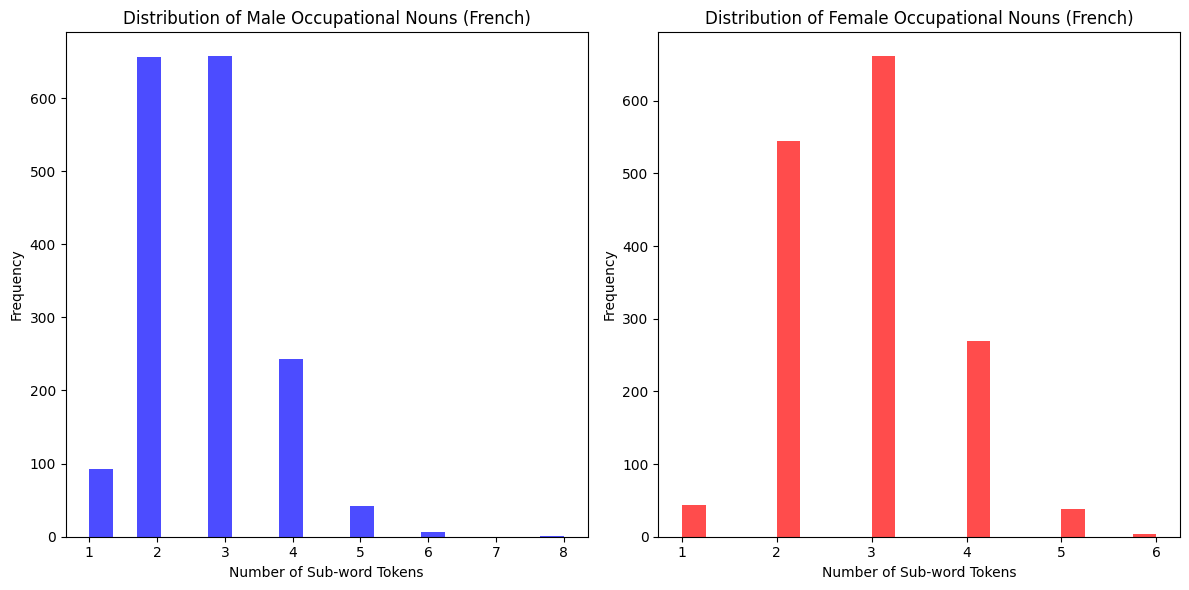

In [ ]:
# Create histograms for male and female tokens
plt.figure(figsize=(12, 6))

# Plot for male tokens
plt.subplot(1, 2, 1)
plt.hist([len(tokens) for tokens in male_tokens], bins=20, color='blue', alpha=0.7)
plt.xlabel('Number of Sub-word Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Male Occupational Nouns (French)')

# Plot for female tokens
plt.subplot(1, 2, 2)
plt.hist([len(tokens) for tokens in female_tokens], bins=20, color='red', alpha=0.7)
plt.xlabel('Number of Sub-word Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Female Occupational Nouns (French)')

plt.tight_layout()
plt.show()

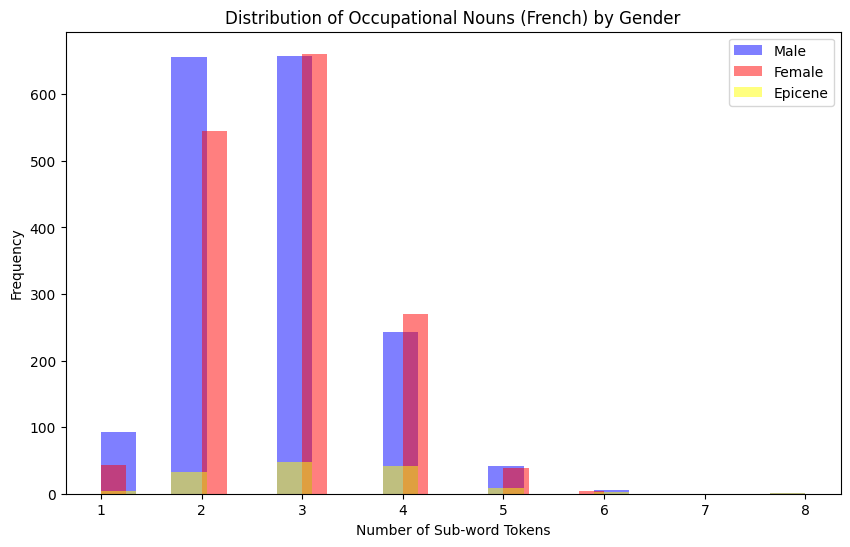

In [ ]:
# Create histograms for male and female tokens
plt.figure(figsize=(10, 6))

# Plot for male tokens (in blue)
plt.hist([len(tokens) for tokens in male_tokens], bins=20, color='blue', alpha=0.5, label='Male')
plt.xlabel('Number of Sub-word Tokens')
plt.ylabel('Frequency')

# Plot for female tokens (in red)
plt.hist([len(tokens) for tokens in female_tokens], bins=20, color='red', alpha=0.5, label='Female')
plt.xlabel('Number of Sub-word Tokens')
plt.ylabel('Frequency')

# Plot for epicene tokens (in yellow)
plt.hist([len(tokens) for tokens in epicene_tokens], bins=20, color='yellow', alpha=0.5, label='Epicene')
plt.xlabel('Number of Sub-word Tokens')
plt.ylabel('Frequency')

plt.legend()
plt.title('Distribution of Occupational Nouns (French) by Gender')
plt.show()

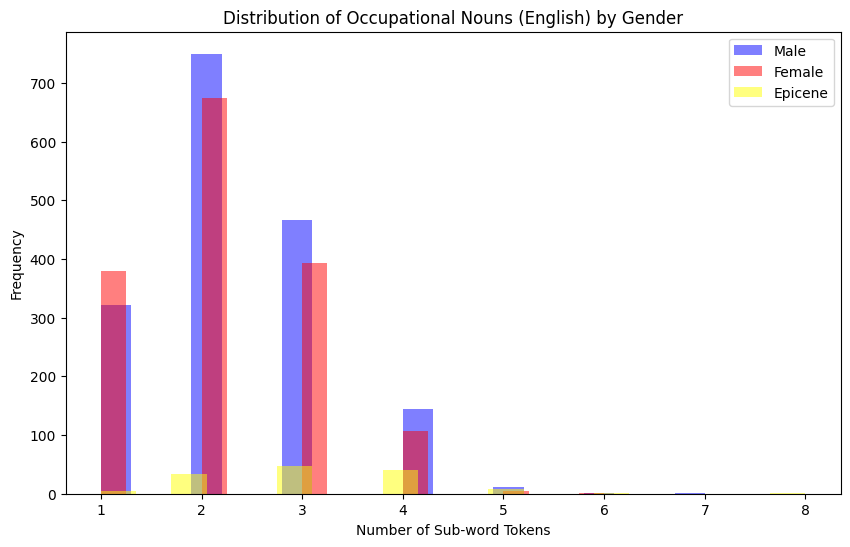

In [ ]:
# Create histograms for male and female tokens
plt.figure(figsize=(10, 6))

# Plot for male tokens (in blue)
plt.hist([len(tokens) for tokens in male_tokens_en], bins=20, color='blue', alpha=0.5, label='Male')
plt.xlabel('Number of Sub-word Tokens')
plt.ylabel('Frequency')

# Plot for female tokens (in red)
plt.hist([len(tokens) for tokens in female_tokens_en], bins=20, color='red', alpha=0.5, label='Female')
plt.xlabel('Number of Sub-word Tokens')
plt.ylabel('Frequency')

# Plot for epicene tokens (in yellow)
plt.hist([len(tokens) for tokens in epicene_tokens_en], bins=20, color='yellow', alpha=0.5, label='Epicene')
plt.xlabel('Number of Sub-word Tokens')
plt.ylabel('Frequency')

plt.legend()
plt.title('Distribution of Occupational Nouns (English) by Gender')
plt.show()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Corpus BLEU Score using a multilingual model: 0.7600007440854316
Corpus BLEU Score using a multilingual model: 0.7600007440854316
Corpus BLEU Score using a multilingual model: 0.7600007440854316
Corpus BLEU Score using a multilingual model: 0.7600007440854316
Corpus BLEU Score using a multilingual model: 0.7600007440854316


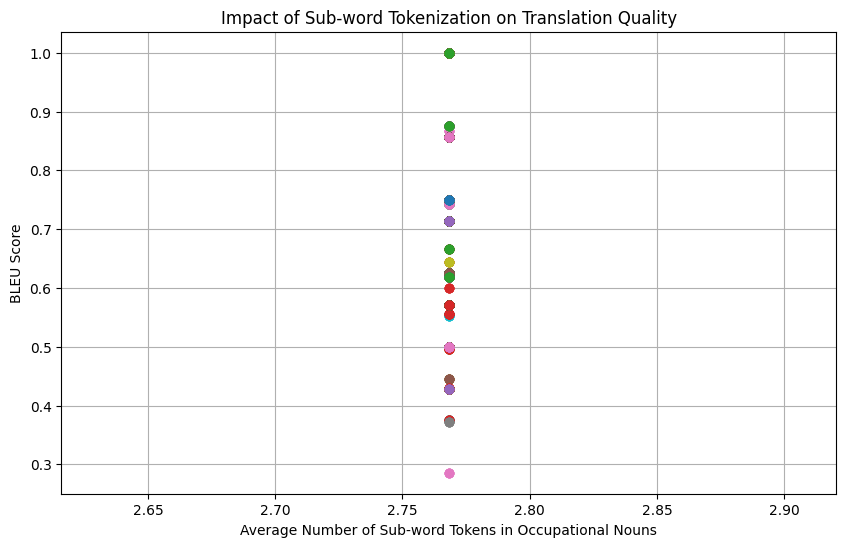

In [ ]:
# Define a range of sub-tokenization levels
sub_tokenization_levels = [100, 200, 300, 400, 500]

# Initialize lists to store BLEU scores and token counts
bleu_scores = []
token_counts = []

# Calculate BLEU scores for different sub-tokenization levels
for sub_tokenization_level in sub_tokenization_levels:
    # Sub-tokenize all nouns using the specified level
    male_tokens = [tokenizer_mbart.tokenize(noun, max_length=sub_tokenization_level) for noun in male_occ_nouns]
    female_tokens = [tokenizer_mbart.tokenize(noun, max_length=sub_tokenization_level) for noun in female_occ_nouns]

    # Calculate average token count for the current sub-tokenization level
    avg_token_count = (np.mean([len(tokens) for tokens in male_tokens]) + np.mean([len(tokens) for tokens in female_tokens])) / 2
    token_counts.append(avg_token_count)

    # Calculate BLEU scores for the current sub-tokenization level
    bleu_score = calculate_bleu_score("multilingual", male_df['Reference translations'], male_df["Multilingual translations"])
    bleu_scores.append(bleu_score)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(token_counts, bleu_scores, marker='o', linestyle='-')
plt.xlabel('Average Number of Sub-word Tokens in Occupational Nouns')
plt.ylabel('BLEU Score')
plt.title('Impact of Sub-word Tokenization on Translation Quality')
plt.grid(True)
plt.show()